Goal: get a class of regression function

# step 1 define a RKHS function

In [1]:
from mlkl_util import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
kernel_gamma = 1.0 # kernel parameter

In [3]:
this_kernel = rbf_kernel

In [4]:
f0 = rkhsFun(this_kernel, kernel_gamma)  # create the RKHS function

In [5]:
n_x = 10 # num samples
n_dim = 5 # dim of each point
a = np.ones(n_x)/n_x # uniform weightsa
data = np.random.uniform(-1, 1, size=[n_x, n_dim])

## mini unit test, plot an RKHS function

In [6]:
n_x = 10 # num samples
n_dim = 2 # dim of each point
a = np.ones(n_x)/n_x # uniform weights

In [7]:

data = np.random.uniform(-1, 1, size=[n_x, n_dim])

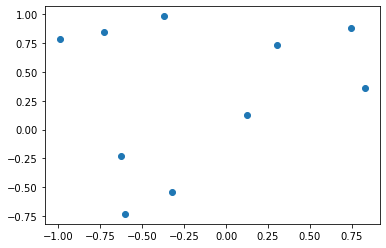

In [8]:
# data to approximate
plt.scatter(x=data[:,0], y=data[:,1])

In [9]:
x_grid = np.linspace(-1, 1, 100)

In [10]:
x_grid = x_grid.reshape(-1,1)

In [11]:
x_grid.shape

(100, 1)

In [12]:
data[:,0].shape

(10,)

In [13]:
# evaluate the RKHS function on grid points to produce a continuous function
f_vals = f0(x_grid, a.T, data[:,0].reshape(-1,1)) 

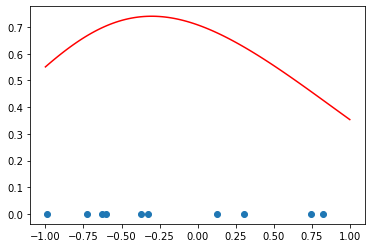

In [14]:
plt.plot(x_grid, f_vals, c='r') # plot the uniform weights interpolant
plt.scatter(x=data[:,0], y=np.zeros_like(data[:,0]))

In [15]:
# Try a different coefficent set than the uniform
a_prime = np.random.rand(n_x) # uniform weights
a_prime = a_prime / np.sum(a_prime)

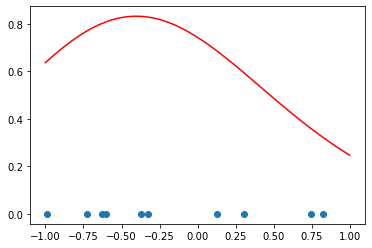

In [16]:
f_vals_prime = f0(x_grid, a_prime.T, data[:,0].reshape(-1,1)) 
plt.plot(x_grid, f_vals_prime, c='r') # plot the uniform weights interpolant
plt.scatter(x=data[:,0], y=np.zeros_like(data[:,0]))

This of course is not the funciton we wanted. Now let's perform regression.

# Ridge Regression

i.e., solve for the coefficient function a

instead of matrix inversion, we use iterative schemes

we use auto diff in pytorch to get gradient of the objective w.r.t. coefficient a

In [17]:
import torch

In [18]:
f_th = rkhsFun(this_kernel, kernel_gamma, is_torch=True)  # create the RKHS function

In [46]:
# create data used for training
a = torch.rand(n_x, requires_grad=True) # uniform weightsa
data_th = 2*np.pi *torch.from_numpy(data[:,0])

## generate the target data

In [20]:
target_th = torch.sin(data_th) + 0.2 * torch.rand_like(data_th)

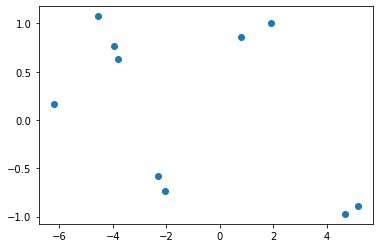

In [21]:
plt.scatter(x=data_th, y=target_th)

In [22]:
f_val = f_th(data_th.reshape(-1,1), a.T, data_th.reshape(-1,1)) 

## mini test, make sure getting the same thing form Torch and numpy

In [23]:
f_val_np = f0(data_th.numpy().reshape(-1,1), a.detach().numpy().T, data_th.numpy().reshape(-1,1)) 

In [24]:
# they should be the same
f_val

tensor([[0.3876, 0.4434, 0.9540, 0.9076, 0.4302, 0.8807, 0.4137, 0.5359, 0.5069,
         0.5158]], grad_fn=<MmBackward0>)

In [25]:
f_val_np

array([0.38760046, 0.44335692, 0.95404842, 0.90759528, 0.43017418,
       0.88067446, 0.41367857, 0.53589836, 0.50694572, 0.515764  ])

## construct objective

In [26]:
def plot_sol_rkhs(a, data_th):
    x_grid = torch.linspace(torch.min(data_th), torch.max(data_th), 100).reshape(-1, 1)
    f_val_plot = f_th(x_grid, a.T, data_th.reshape(-1, 1))
    plt.plot(x_grid.detach().numpy(),
             f_val_plot.detach().numpy().reshape(-1,1),
             c='r')  # plot the uniform weights interpolant


In [27]:
def gd_step(data_th=None, step_size=0.001):
    f_val = f_th(data_th.reshape(-1,1), a.T, data_th.reshape(-1,1)) 
    f_minus_y_sqr = torch.norm(f_val - target_th)**2 # frobenius/2-norm sqr

    K =  this_kernel(data_th.reshape(-1,1), data_th.reshape(-1,1), gamma=kernel_gamma)
    aKa = torch.mm(torch.mm(a.reshape(1,-1), torch.from_numpy(K).float()), a.reshape(-1,1))

    reg_coeff = 0.1
    reg_term = reg_coeff * aKa

    obj_krr = f_minus_y_sqr + reg_term

    obj_krr.backward() # compute grad

    # gradient step

    a.data = a - step_size * a.grad.detach() # gradient step

    a.grad.zero_() # zero gradient

In [28]:
# raise NotImplemented

## before optimization plot

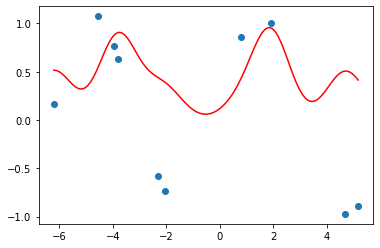

In [29]:
plot_sol_rkhs(a, data_th)
plt.scatter(x=data_th, y=target_th)

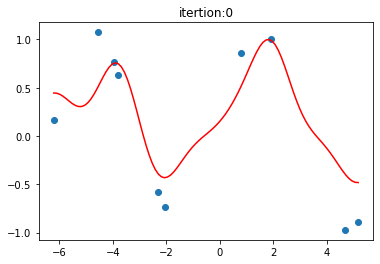

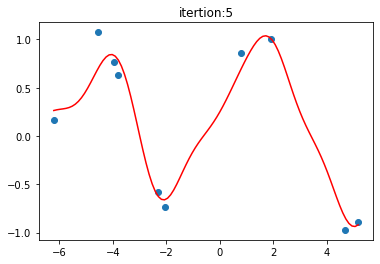

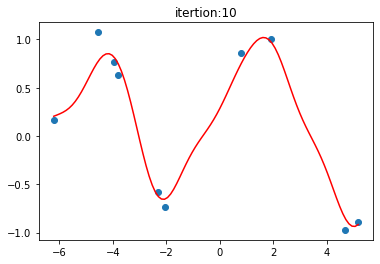

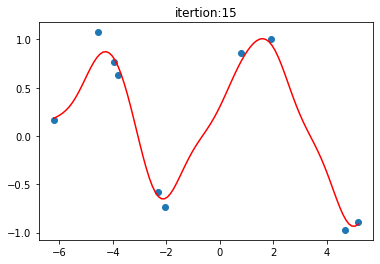

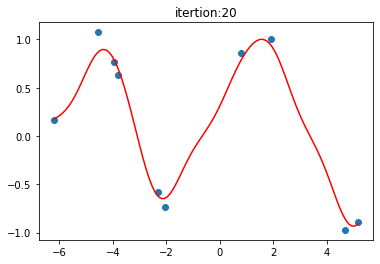

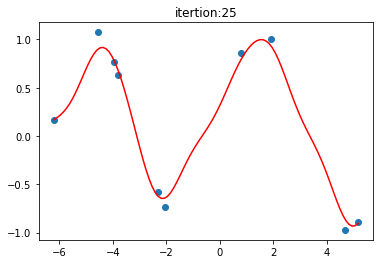

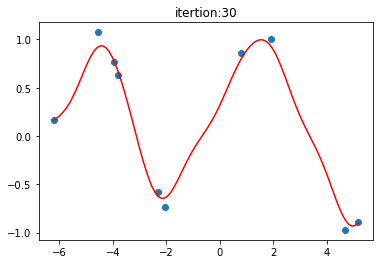

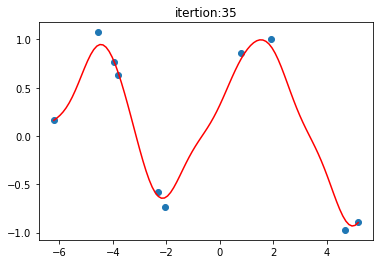

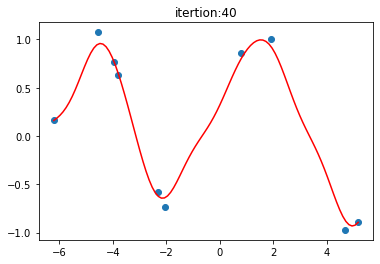

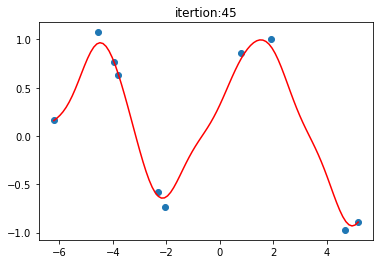

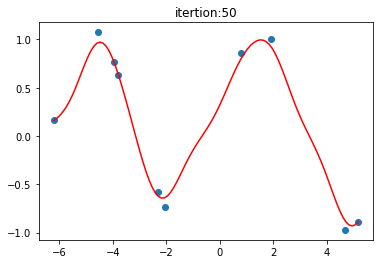

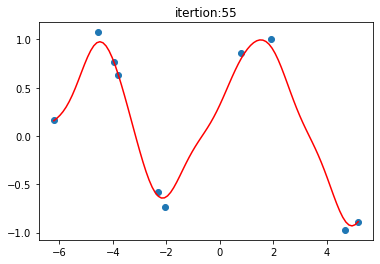

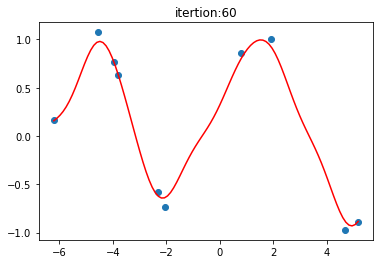

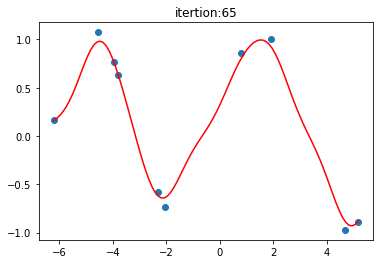

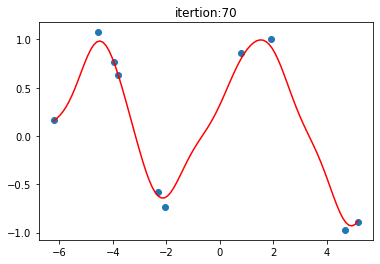

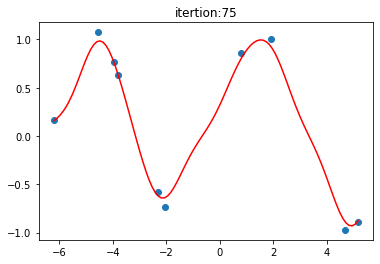

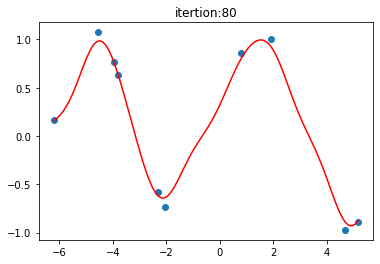

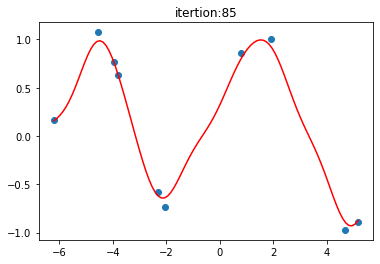

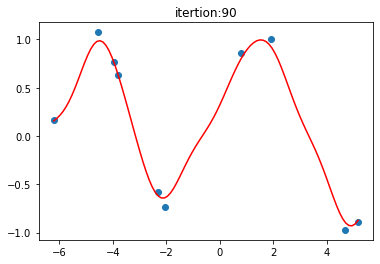

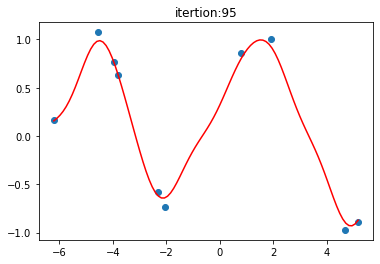

In [30]:
for iter_gd in range(100):
    gd_step(data_th =data_th, step_size=0.1)
    if iter_gd %5 ==0:
        plt.figure()
        plot_sol_rkhs(a, data_th)
        plt.scatter(x=data_th, y=target_th)
        plt.title("itertion:"+str(iter_gd))

## after optimization plot

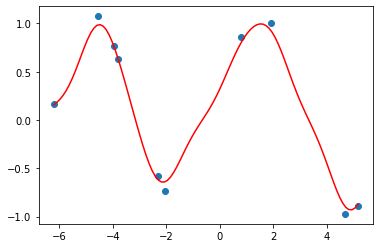

In [31]:
plot_sol_rkhs(a, data_th)
plt.scatter(x=data_th, y=target_th)

# SGD, load data
instead of the whole data batch, we only load the small data batch

In [40]:
import random

In [37]:
data_th

tensor([-2.0340, -2.3299,  1.9162, -3.7926,  0.7987, -3.9520,  5.1836, -4.5693,
         4.6838, -6.2133], dtype=torch.float64)

In [44]:
# build a randomized data loader

# first, we generate a random index
id_rnd = random.randint(0, n_x)

# todo later, we will use mini-batches

In [45]:
# todo: reinialize the data model

tensor(-4.5693, dtype=torch.float64)

In [ ]:
# sgd iter's

for iter_gd in range(100):
    gd_step(data_th =data_th[id_rnd], step_size=0.1)
    if iter_gd %20 ==0:
        plt.figure()
        plot_sol_rkhs(a, data_th)
        plt.scatter(x=data_th, y=target_th)
        plt.title("itertion:"+str(iter_gd))